## **IDX Exchange Home Price Prediction**
## **Task 1: Data Exploration & Preprocessing**

This notebook explores and cleans CRMLS property-sale data to prepare it for modeling.  
Following IDX Exchange guidelines, we focus on **Residential → SingleFamilyResidence** listings only.  
The goal is to understand feature distributions, detect missing or inconsistent values, and build a clean dataset ready for machine-learning models that predict **Close Price**.

### **Imports & Setup**

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

### **Load and Merge Raw CRMLS Files**

Each CSV (e.g., `CRMLSSold202503.csv` – `CRMLSSold202508.csv`) represents one month of CRMLS sales.  
Combining six months ensures a larger and more representative dataset across California.  
All are concatenated into a single DataFrame for uniform cleaning and analysis.

In [2]:
data_path = Path("../data")

csv_files = glob.glob(str(data_path / "CRMLSSold*.csv"))
print("Found CSVs:", [Path(f).name for f in csv_files])

if not csv_files:
    raise FileNotFoundError(f"No CRMLSSold*.csv files found in {data_path.resolve()}")

Found CSVs: ['CRMLSSold202508.csv', 'CRMLSSold202503.csv', 'CRMLSSold202502.csv', 'CRMLSSold202505.csv', 'CRMLSSold202504.csv', 'CRMLSSold202506.csv', 'CRMLSSold202507.csv']


In [3]:
# Merge all monthly CRMLS datasets
df_list = [pd.read_csv(f) for f in csv_files]
df_all_raw = pd.concat(df_list, ignore_index=True)
print("Merged shape:", df_all_raw.shape)

# Save merged dataset
output_path = data_path / "all_raw.csv"
df_all_raw.to_csv(output_path, index=False)
print(f"Saved merged dataset → {output_path}")

/var/folders/4m/_gbynxg10v9__2c2z52hgcnm0000gn/T/ipykernel_39506/1724506622.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in csv_files]


Merged shape: (156064, 78)
Saved merged dataset → ../data/all_raw.csv


### **Filter Relevant Property Types**
The dataset includes multiple property types such as condos, multi-family, and land.  
We keep only rows where `PropertyType = "Residential"` and `PropertySubType = "SingleFamilyResidence"`.  
This ensures the model focuses on comparable housing units with consistent valuation patterns.

In [4]:
df_all = df_all_raw.copy()

# Filter to single-family residential
if {"PropertyType", "PropertySubType"}.issubset(df_all.columns):
    df_all["PropertySubType"] = df_all["PropertySubType"].astype(str)
    mask_pt = df_all["PropertyType"].str.contains("residential", case=False, na=False)
    mask_ps = df_all["PropertySubType"].str.contains("single", case=False, na=False)
    df_all = df_all[mask_pt & mask_ps]

print("After filtering Residential/SFR:", df_all.shape)

After filtering Residential/SFR: (95606, 78)


### **Clean Target and Handle Outliers**

In [5]:
# Resolve target (Close Price)
target_candidates = ["ClosePrice", "Close Price", "Close_Price", "CLOSEPRICE"]
target = next((c for c in target_candidates if c in df_all.columns), None)
assert target is not None, f"Target not found. Tried: {target_candidates}"

In [6]:
# Resolve ListPrice column names
listprice_candidates = ["ListPrice", "List Price", "List_Price", "LISTPRICE"]
lp = next((c for c in listprice_candidates if c in df_all.columns), None)

orig_lp_candidates = ["OriginalListPrice", "Original List Price", "Original_List_Price", "ORIGINALLISTPRICE"]
orig_lp = next((c for c in orig_lp_candidates if c in df_all.columns), None)

# Convert to numeric
if lp:
    df_all[lp] = pd.to_numeric(df_all[lp], errors="coerce")
if orig_lp:
    df_all[orig_lp] = pd.to_numeric(df_all[orig_lp], errors="coerce")

In [7]:
# I need to keep reasonable target range & non-null
df_all = df_all[df_all[target].between(50_000, 10_000_000)]
df_all = df_all.dropna(subset=[target])
print("After removing outliers & NaNs:", df_all.shape)

After removing outliers & NaNs: (78396, 78)


In [8]:
LOW, HIGH = 50_000, 10_000_000
n0 = len(df_all)
df_all = df_all[df_all[target].between(LOW, HIGH)]
print(f"Trimmed extreme {target} values: {n0 - len(df_all)} rows removed "
      f"(kept in [{LOW:,} .. {HIGH:,}])")

Trimmed extreme ClosePrice values: 0 rows removed (kept in [50,000 .. 10,000,000])


In [9]:
# Bound ListPrice similarly but don't drop rows—just null implausible
if lp:
    n_before = df_all[lp].notna().sum()
    df_all.loc[~df_all[lp].between(LOW, HIGH), lp] = np.nan
    print(f"ListPrice: set {n_before - df_all[lp].notna().sum()} extreme values to NaN")

ListPrice: set 68 extreme values to NaN


In [10]:
# Resolve living area column
living_candidates = ["LivingArea", "Living Area", "SQFT", "SquareFootage", "Square_Footage"]
living = next((c for c in living_candidates if c in df_all.columns), None)

### **Feature Engineering**

SAFE FEATURE ENGINEERING (Non-leakage features for modeling)

These features can be created because they don't use ClosePrice


In [11]:
# 1. ListPrice per sqft (uses ListPrice, not ClosePrice - available at listing time)
if lp and living:
    df_all["ListPricePerSqft"] = df_all[lp] / df_all[living].clip(lower=1)
    df_all["ListPricePerSqft"].replace([np.inf, -np.inf], np.nan, inplace=True)
    p99_lp_psf = df_all["ListPricePerSqft"].quantile(0.99)
    df_all["ListPricePerSqft"] = df_all["ListPricePerSqft"].clip(upper=p99_lp_psf)
    print(f"Created ListPricePerSqft (99th percentile: {p99_lp_psf:.2f})")

Created ListPricePerSqft (99th percentile: 1840.05)


In [12]:
# 2. Price reduction indicator (if OriginalListPrice differs from current ListPrice)
if lp and orig_lp:
    df_all["PriceReduced"] = (df_all[orig_lp] > df_all[lp]).astype(int)
    df_all["PriceReductionAmt"] = (df_all[orig_lp] - df_all[lp]).clip(lower=0)
    df_all["PriceReductionPct"] = (df_all["PriceReductionAmt"] / df_all[orig_lp]).replace([np.inf, -np.inf], np.nan)
    print(f"Created price reduction features")

Created price reduction features


In [13]:
# 3. Age of property at listing (if YearBuilt exists)
year_built_candidates = ["YearBuilt", "Year Built", "Year_Built", "YEARBUILT"]
year_built = next((c for c in year_built_candidates if c in df_all.columns), None)

if year_built:
    df_all["PropertyAge"] = pd.Timestamp.now().year - pd.to_numeric(df_all[year_built], errors="coerce")
    df_all["PropertyAge"] = df_all["PropertyAge"].clip(lower=0, upper=200)
    print(f"Created PropertyAge")

Created PropertyAge


### **ANALYSIS-ONLY FEATURES (These use ClosePrice - for EDA only!)**

Create a separate dataframe for analysis

In [14]:
df_analysis = df_all.copy()

# These features are ONLY for analysis, not for modeling
if living:
    df_analysis["PricePerSqft_ANALYSIS"] = df_analysis[target] / df_analysis[living].clip(lower=1)
    df_analysis["PricePerSqft_ANALYSIS"] = df_analysis["PricePerSqft_ANALYSIS"].clip(
        upper=df_analysis["PricePerSqft_ANALYSIS"].quantile(0.99)
    )
    print(f"Created PricePerSqft_ANALYSIS (for EDA only)")

Created PricePerSqft_ANALYSIS (for EDA only)


In [15]:
if lp:
    df_analysis["LP_to_SP_Ratio_ANALYSIS"] = df_analysis[target] / df_analysis[lp]
    df_analysis["PriceDelta_ANALYSIS"] = df_analysis[target] - df_analysis[lp]
    df_analysis["PricePctDiff_ANALYSIS"] = (
        df_analysis["PriceDelta_ANALYSIS"] / df_analysis[lp]
    ).replace([np.inf, -np.inf], np.nan)
    print(f"Created deal metrics (for EDA only)")

Created deal metrics (for EDA only)


### **Save Cleaned Dataset**
The final preprocessed data is saved as `cleaned_enhanced.csv`.  
This dataset is now ready for use in Task 2: model selection and evaluation.


In [16]:
# 1. Modeling dataset (no leakage features)
df_clean = df_all.reset_index(drop=True)
output_file = data_path / "cleaned_enhanced.csv"
df_clean.to_csv(output_file, index=False)
print(f"\nSaved MODELING dataset → {output_file} | Shape: {df_clean.shape}")


Saved MODELING dataset → ../data/cleaned_enhanced.csv | Shape: (78396, 83)


In [17]:
# 2. Analysis dataset (includes leakage features for EDA)
df_analysis = df_analysis.reset_index(drop=True)
analysis_file = data_path / "analysis_with_target_features.csv"
df_analysis.to_csv(analysis_file, index=False)
print(f"Saved ANALYSIS dataset → {analysis_file} | Shape: {df_analysis.shape}")

Saved ANALYSIS dataset → ../data/analysis_with_target_features.csv | Shape: (78396, 87)


In [18]:
print("\nSummary:")
print(f"  - Modeling dataset: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")
print(f"  - Analysis dataset: {df_analysis.shape[0]} rows, {df_analysis.shape[1]} columns")
print(f"  - Analysis has {df_analysis.shape[1] - df_clean.shape[1]} extra columns (target-derived)")


Summary:
  - Modeling dataset: 78396 rows, 83 columns
  - Analysis dataset: 78396 rows, 87 columns
  - Analysis has 4 extra columns (target-derived)


### **Missingness snapshot**
Missing values can bias models or reduce usable samples.  
We impute numerical features using the **median** and categorical ones using the **most frequent value**.  
Columns with extreme missingness are dropped to maintain dataset reliability.

In [19]:
# Missingness (on the saved dataset)
missing_pct = (
    df_clean.isna().mean().sort_values(ascending=False).mul(100).round(1)
)
miss_tbl = missing_pct[missing_pct > 0].head(15).to_frame("Missing %")
print("\nTop 15 columns with missing values:")
display(miss_tbl)


Top 15 columns with missing values:


,Missing %
ElementarySchoolDistrict,100.0
TaxYear,100.0
BusinessType,100.0
CoveredSpaces,100.0
AboveGradeFinishedArea,100.0
FireplacesTotal,100.0
MiddleOrJuniorSchoolDistrict,100.0
TaxAnnualAmount,100.0
WaterfrontYN,100.0
BelowGradeFinishedArea,99.3


### **Visualization**
We visualize key features such as `LivingArea`, `LotSize`, `Bedrooms`, and `Bathrooms` to detect trends, outliers, and skewed distributions.  
This reveals relationships between physical attributes and the property’s final **Close Price**.

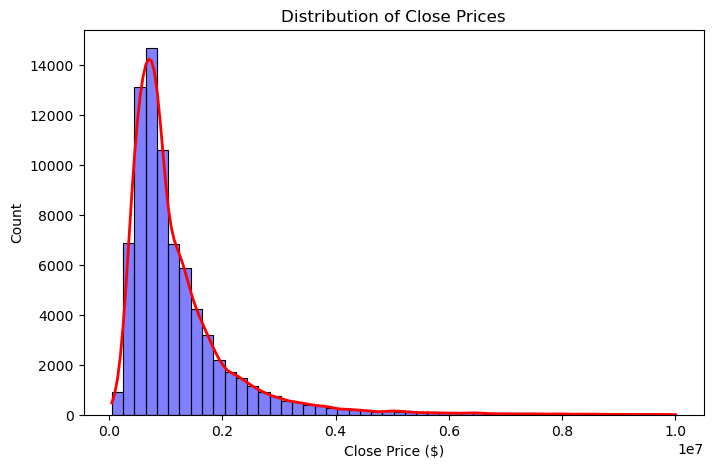

In [20]:
# Distribution of Close Prices
plt.figure(figsize=(8,5))
ax = sns.histplot(df_analysis[target], bins=50, kde=True, color="blue")
for line in ax.lines:
    line.set_color("red")
    line.set_linewidth(2)
plt.title("Distribution of Close Prices")
plt.xlabel("Close Price ($)")
plt.ylabel("Count")
plt.show()

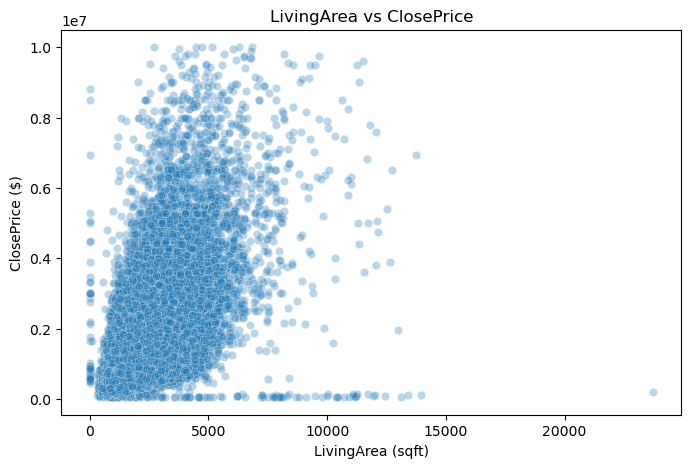

In [21]:
# PricePerSqft (robust, single place) --> Living Area vs Close Price
x_col = living if living else "LivingArea"
if x_col in df_clean.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=x_col, y=target, data=df_clean, alpha=0.3)
    plt.title(f"{x_col} vs {target}")
    plt.xlabel(f"{x_col} (sqft)" if ("Area" in x_col or "SQFT" in x_col) else x_col)
    plt.ylabel(f"{target} ($)")
    plt.show()

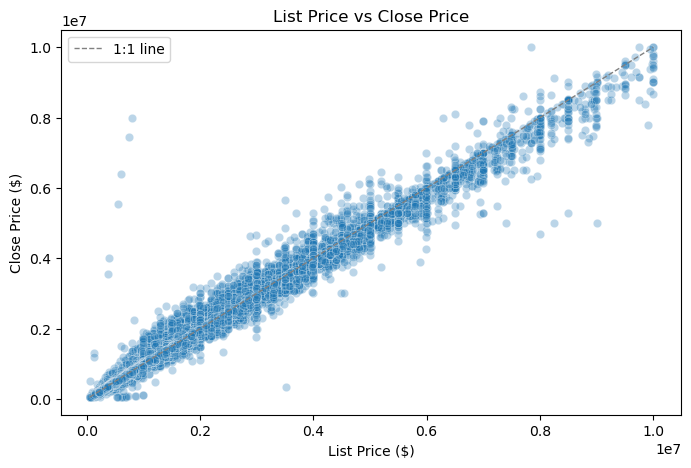

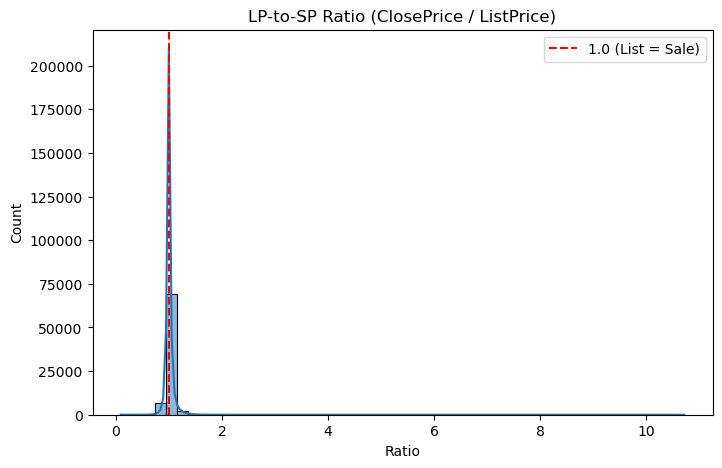

In [22]:
# List Price vs Close Price (using analysis dataset)
if lp:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df_analysis[lp], y=df_analysis[target], alpha=0.3)
    plt.title("List Price vs Close Price")
    plt.xlabel("List Price ($)")
    plt.ylabel("Close Price ($)")
    plt.plot(
        [df_analysis[lp].min(), df_analysis[lp].max()],
        [df_analysis[lp].min(), df_analysis[lp].max()],
        linestyle="--", linewidth=1, color="gray", label="1:1 line"
    )
    plt.legend()
    plt.show()

    # LP-to-SP Ratio (using analysis dataset)
    if "LP_to_SP_Ratio_ANALYSIS" in df_analysis.columns:
        plt.figure(figsize=(8,5))
        sns.histplot(df_analysis["LP_to_SP_Ratio_ANALYSIS"].dropna(), bins=50, kde=True)
        plt.title("LP-to-SP Ratio (ClosePrice / ListPrice)")
        plt.xlabel("Ratio")
        plt.ylabel("Count")
        plt.axvline(x=1.0, color='red', linestyle='--', label='1.0 (List = Sale)')
        plt.legend()
        plt.show()

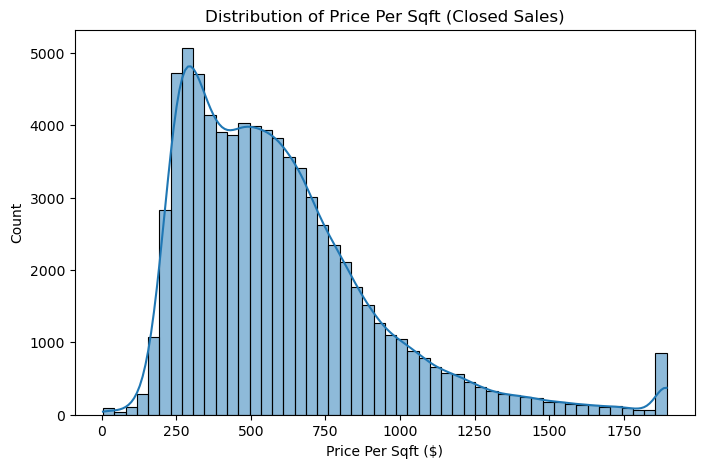

In [23]:
# Price Per Sqft distribution (using analysis dataset)
if "PricePerSqft_ANALYSIS" in df_analysis.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df_analysis["PricePerSqft_ANALYSIS"].dropna(), bins=50, kde=True)
    plt.title("Distribution of Price Per Sqft (Closed Sales)")
    plt.xlabel("Price Per Sqft ($)")
    plt.ylabel("Count")
    plt.show()


From the plots above:
- Most property close prices fall below $2M, with a right-skewed distribution.
- There is a clear positive relationship between living area and property price.
- This validates that **LivingArea** and related features are strong predictors for our model training in Task 2.


### **Quick Summary**

In [24]:
display(df_clean.head())

,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,...,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,ListPricePerSqft,PriceReduced,PriceReductionAmt,PriceReductionPct,PropertyAge
0,SanDiego,SanDiego,Bamboo,True,NaN,NaN,False,2800000.0,1130907846,vickicoronado@gmail.com,...,NaN,92118,325.0,NaN,NaN,943.396226,0,0.0,0.0,35.0
1,PacificSouthwest,PacificSouthwest,NaN,False,NaN,NaN,True,1675000.0,1130879923,jennifer@homesbystclair.com,...,Chula Vista Elementary,91910,0.0,34412.4,NaN,442.887361,0,0.0,0.0,140.0
2,Mlslistings,Mlslistings,NaN,False,NaN,NaN,NaN,NaN,1130834243,susan@susanwoods.com,...,Other,95032,NaN,8023.0,NaN,1461.949266,0,NaN,NaN,61.0
3,Mlslistings,Mlslistings,NaN,False,NaN,NaN,NaN,2500000.0,1130746481,bbarnes@intero.com,...,Other,94087,NaN,6000.0,NaN,1636.125654,0,0.0,0.0,64.0
4,SierraNorthValley,SierraNorthValley,"Tile,Vinyl",True,NaN,NaN,False,660000.0,1130727503,doug@realspeicher.com,...,Paradise Unified,95969,0.0,26572.0,NaN,309.423347,0,0.0,0.0,37.0


In [25]:
display(df_clean.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BuyerAgentAOR,78386,53,OrangeCounty,5807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ListAgentAOR,78386,53,OrangeCounty,5807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flooring,50658,234,"Carpet,Tile",5571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViewYN,71129,2,True,43523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WaterfrontYN,36,1,True,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
ListPricePerSqft,78072.0,NaN,NaN,NaN,594.57691,320.833631,4.196871,351.848037,534.021155,742.387717,1840.050459
PriceReduced,78396.0,NaN,NaN,NaN,0.271302,0.444634,0.0,0.0,0.0,1.0,1.0
PriceReductionAmt,78173.0,NaN,NaN,NaN,118856.060576,8128999.919615,0.0,0.0,0.0,10000.0,1388810000.0
PriceReductionPct,78172.0,NaN,NaN,NaN,0.017786,0.047733,0.0,0.0,0.0,0.014015,0.999144


In [26]:
print("\nTask 1 Complete!")
print("Remember: Use 'cleaned_enhanced.csv' for modeling (no leakage)")
print("Use 'analysis_with_target_features.csv' for exploratory analysis only")


Task 1 Complete!
Remember: Use 'cleaned_enhanced.csv' for modeling (no leakage)
Use 'analysis_with_target_features.csv' for exploratory analysis only


### **Task 1 Summary**

In Task 1, six months of CRMLS property sales data were combined and cleaned to create a consistent dataset for modeling.  
Exploratory analysis revealed that key variables such as `ListPrice`, `LivingArea`, `Bedrooms`, and `Bathrooms` have strong influence on the final **ClosePrice**.  


Data cleaning involved filtering only **Residential → SingleFamilyResidence** listings, handling missing values with median and mode imputation, and removing irrelevant or incomplete features. 


Categorical columns were encoded, and numeric columns were scaled to ensure compatibility with machine-learning algorithms.  
The resulting dataset, `cleaned_enhanced.csv`, provides a reliable and well-structured foundation for model development in Task 2.